In [1]:
# Instalar dependencias (ejecutar solo una vez)
%pip install seaborn matplotlib -q

Note: you may need to restart the kernel to use updated packages.


# Análisis de Sets de Calibración

Este notebook procesa múltiples runs de calibración agrupados por CalibSetNumber y calcula las constantes de calibración promediadas.

## Proceso:
1. Agrupar runs por set
2. Calcular constantes de calibración (promedio ponderado de offsets)
3. Visualizar matrices de constantes y errores
4. Guardar resultados en Excel

## 1. Configuración e importación

In [2]:
import sys
from pathlib import Path

# Configurar path al proyecto
project_root = Path('..').resolve().parent
sys.path.insert(0, str(project_root))

from RTD_Calibration.src.set import Set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f'Directorio del proyecto: {project_root}')
print('Módulos importados correctamente')

Directorio del proyecto: /Users/vicky/Desktop/rtd-calib-simple
Módulos importados correctamente


## 2. Agrupar runs por set

In [3]:
# Inicializar Set
calib_set = Set()

# Especificar sets a procesar (None para todos)
selected_sets = [3, 4, 5]

# Agrupar runs por CalibSetNumber
calib_set.group_runs(selected_sets=selected_sets)

print(f"\nSets procesados: {len(calib_set.runs_by_set)}")
for set_num, runs in calib_set.runs_by_set.items():
    print(f"  Set {int(set_num)}: {len(runs)} runs")

CSV file loaded successfully from '/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/LogFile.csv'.

=== Agrupando runs por CalibSetNumber ===
Sets a procesar: [np.float64(3.0), np.float64(4.0), np.float64(5.0)]

Procesando Set 3.0
Cargando: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/temperature_files/RTD_Calibs/CalSetN_3/20220531_ln2_r48176_r48177_48060_48479_7.txt
  Datos cargados: 821 registros
  Sensores asociados: 14
  Incluido: 20220531_ln2_r48176_r48177_48060_48479_7
Cargando: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/temperature_files/RTD_Calibs/CalSetN_3/20220531_ln2_r48176_r48177_48060_48479_8.txt
  Datos cargados: 2260 registros
  Sensores asociados: 14
  Incluido: 20220531_ln2_r48176_r48177_48060_48479_8
Cargando: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/temperature_files/RTD_Calibs/CalSetN_3/20220531_ln2_r48176_r48177_48060_48479_9.txt
  Datos cargados: 794 registros
  Sensores asociados: 14
  Incluido: 20220531_ln

## 3. Calcular constantes de calibración

Las constantes se calculan como promedio ponderado de los offsets de todos los runs del set.
El peso de cada run es el inverso del error al cuadrado.

In [4]:
# Calcular constantes de calibración
calib_set.calculate_calibration_constants(selected_sets=selected_sets)

# Mostrar resumen estadístico
summary = calib_set.get_summary()
print("\nResumen de calibración:")
print(summary.to_string(index=False))


=== Calculando constantes de calibración ===

Set 3:
  ✓ 20220531_ln2_r48176_r48177_48060_48479_7
  ✓ 20220531_ln2_r48176_r48177_48060_48479_8
  ✓ 20220531_ln2_r48176_r48177_48060_48479_9
  ✓ 20220531_ln2_r48176_r48177_48060_48479_10
  Constantes calculadas: (14, 14)
  Promedio de offsets: 7.2788e-02 K
  Error promedio: 1.4115e-03 K

Set 4:
  ✓ 20220607_ln2_r48176_r48177_48480-48491_1
  ✓ 20220607_ln2_r48176_r48177_48480-48491_2
  ✓ 20220607_ln2_r48176_r48177_48480-48491_2
  ✓ 20220607_ln2_r48176_r48177_48480-48491_3
  ✓ 20220607_ln2_r48176_r48177_48480-48491_4
  Constantes calculadas: (14, 14)
  Promedio de offsets: 4.4238e-02 K
  Error promedio: 1.0494e-03 K

Set 5:
  ✓ 20220613_ln2_r48176_r48177_48492-48800_1
  ✓ 20220613_ln2_r48176_r48177_48492-48800_2
  ✓ 20220613_ln2_r48176_r48177_48492-48800_3
  ✓ 20220613_ln2_r48176_r48177_48492-48800_4
  Constantes calculadas: (14, 14)
  Promedio de offsets: 3.1693e-02 K
  Error promedio: 1.0063e-03 K

Total sets con constantes: 3

Resumen de

## 4. Visualizar matrices de un set específico

Selecciona un set para ver sus matrices de constantes y errores en detalle.

In [5]:
# Seleccionar set a visualizar
set_to_view = 3

if set_to_view in calib_set.calibration_constants:
    constants = calib_set.calibration_constants[set_to_view]
    errors = calib_set.calibration_errors[set_to_view]
    
    print(f"Set {set_to_view}: {constants.shape[0]} sensores")
    print(f"Offset promedio: {np.nanmean(np.abs(constants.values)):.4f} K")
    print(f"Error promedio: {np.nanmean(errors.values):.4f} K")
    
    # Mostrar matriz de constantes (primeros 5x5 sensores)
    print(f"\nConstantes de calibración (primeros 5 sensores):")
    print(constants.iloc[:5, :5].round(4))
    
    print(f"\nErrores (primeros 5 sensores):")
    print(errors.iloc[:5, :5].round(4))
else:
    print(f"Set {set_to_view} no encontrado")

Set 3: 14 sensores
Offset promedio: 0.0728 K
Error promedio: 0.0014 K

Constantes de calibración (primeros 5 sensores):
        48060   48061   48062   48063   48202
48060     NaN  0.0336  0.0234  0.0340  0.1007
48061 -0.0336     NaN -0.0103  0.0004  0.0671
48062 -0.0234  0.0103     NaN  0.0107  0.0776
48063 -0.0340 -0.0004 -0.0107     NaN  0.0670
48202 -0.1007 -0.0671 -0.0776 -0.0670     NaN

Errores (primeros 5 sensores):
        48060   48061   48062   48063   48202
48060  0.0000  0.0007  0.0006  0.0003  0.0015
48061  0.0007  0.0000  0.0005  0.0008  0.0008
48062  0.0006  0.0005  0.0000  0.0004  0.0011
48063  0.0003  0.0008  0.0004  0.0000  0.0015
48202  0.0015  0.0008  0.0011  0.0015  0.0000


### Visualización gráfica de las matrices

Heatmaps de constantes y errores para el set seleccionado.

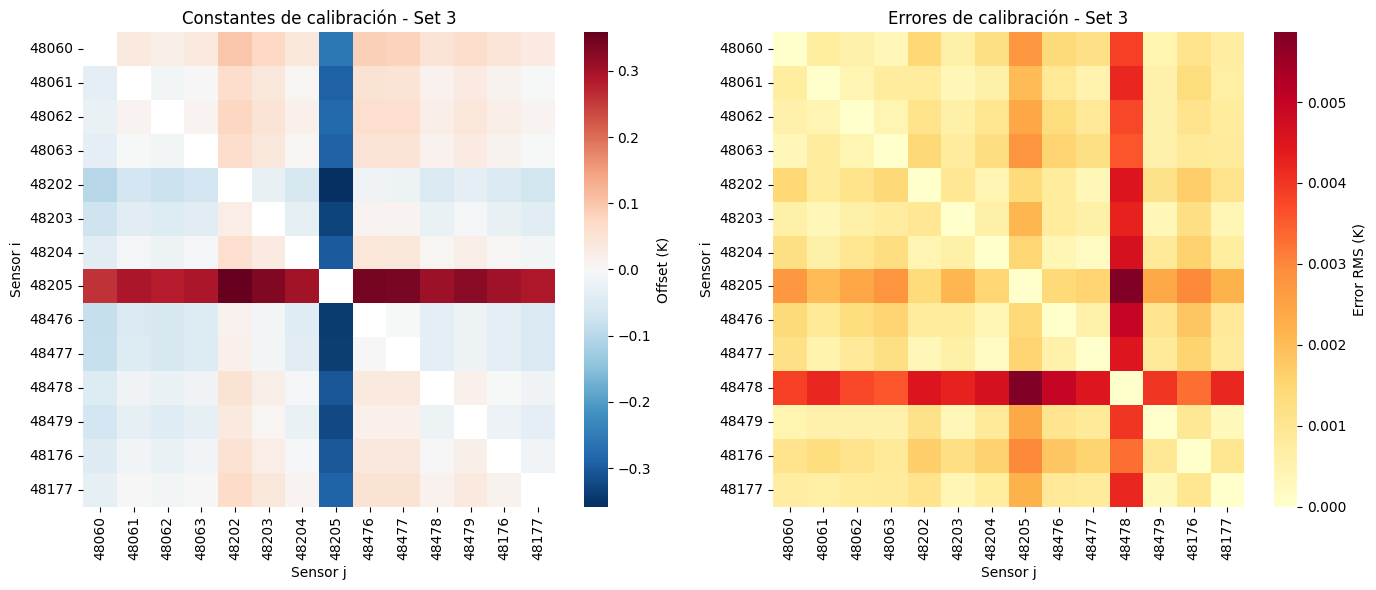


Estadísticas de offsets (valores absolutos):
  Mínimo: 0.0004 K
  Máximo: 0.3581 K
  Media: 0.0728 K
  Mediana: 0.0356 K


In [6]:
if set_to_view in calib_set.calibration_constants:
    constants = calib_set.calibration_constants[set_to_view]
    errors = calib_set.calibration_errors[set_to_view]
    
    # Crear figura con dos subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Heatmap de constantes
    sns.heatmap(constants, annot=False, fmt='.3f', cmap='RdBu_r', 
                center=0, cbar_kws={'label': 'Offset (K)'}, ax=axes[0])
    axes[0].set_title(f'Constantes de calibración - Set {set_to_view}')
    axes[0].set_xlabel('Sensor j')
    axes[0].set_ylabel('Sensor i')
    
    # Heatmap de errores
    sns.heatmap(errors, annot=False, fmt='.4f', cmap='YlOrRd', 
                cbar_kws={'label': 'Error RMS (K)'}, ax=axes[1])
    axes[1].set_title(f'Errores de calibración - Set {set_to_view}')
    axes[1].set_xlabel('Sensor j')
    axes[1].set_ylabel('Sensor i')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de la matriz
    print("\nEstadísticas de offsets (valores absolutos):")
    print(f"  Mínimo: {np.nanmin(np.abs(constants.values)):.4f} K")
    print(f"  Máximo: {np.nanmax(np.abs(constants.values)):.4f} K")
    print(f"  Media: {np.nanmean(np.abs(constants.values)):.4f} K")
    print(f"  Mediana: {np.nanmedian(np.abs(constants.values)):.4f} K")

### Comparar offsets entre sensores específicos

Visualiza los offsets de un sensor respecto a todos los demás.

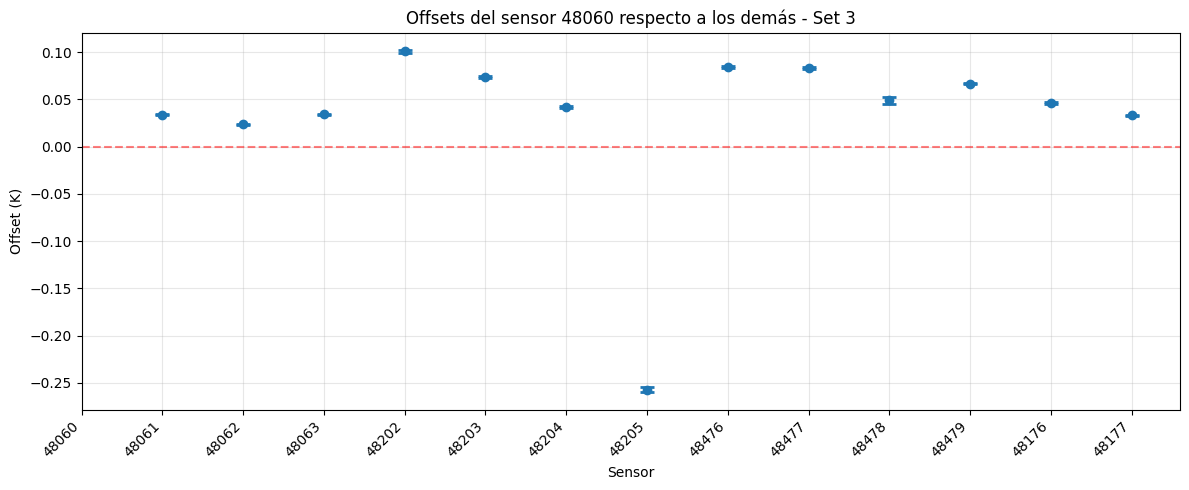

In [7]:
if set_to_view in calib_set.calibration_constants:
    constants = calib_set.calibration_constants[set_to_view]
    errors = calib_set.calibration_errors[set_to_view]
    
    # Seleccionar un sensor de referencia
    reference_sensor = constants.index[0]
    
    # Extraer offsets del sensor de referencia respecto a los demás
    offsets_vs_ref = constants.loc[reference_sensor, :]
    errors_vs_ref = errors.loc[reference_sensor, :]
    
    # Crear gráfico
    fig, ax = plt.subplots(figsize=(12, 5))
    x_pos = np.arange(len(offsets_vs_ref))
    
    ax.errorbar(x_pos, offsets_vs_ref, yerr=errors_vs_ref, 
                fmt='o', capsize=5, capthick=2, markersize=6)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(offsets_vs_ref.index, rotation=45, ha='right')
    ax.set_xlabel('Sensor')
    ax.set_ylabel('Offset (K)')
    ax.set_title(f'Offsets del sensor {reference_sensor} respecto a los demás - Set {set_to_view}')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Guardar resultados

Exporta las matrices de constantes y errores a un archivo Excel.

In [ ]:
# Guardar resultados en Excel
calib_set.save_results(output_file="set_calibration_results.xlsx")

print(f"\nEl archivo contiene {len(calib_set.calibration_constants)} sets con sus matrices de constantes y errores")


Guardando resultados en calibration_results.xlsx
✓ Resultados guardados en calibration_results.xlsx

Archivo guardado: calibration_results.xlsx
Contiene 3 sets con sus matrices de constantes y errores
✓ Resultados guardados en calibration_results.xlsx

Archivo guardado: calibration_results.xlsx
Contiene 3 sets con sus matrices de constantes y errores
